<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# set max printout options for pandas:
pd.options.display.max_columns = 90
pd.options.display.max_colwidth = 300

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
houses = pd.read_csv('./housing.csv')

In [3]:
# A: Shape of the entire dataframe
print("houses: " + str(houses.shape))

houses: (1460, 81)


In [4]:
# Number of Duplicates
(houses.shape[0]) - len(set(houses.Id))

0

In [5]:
# Based on datadescription.txt the subset of houses that are residential only
residential = houses[houses.MSZoning.isin(['FV','RH','RL','RP','RM'])]
residential.shape

(1450, 81)

In [6]:
# Value counts of the different types of residential zones
residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [7]:
# Drop the Id column
residential = residential.drop('Id', axis=1)
print("residential: " + str(residential.shape))

residential: (1450, 80)


### Exploratory Data Analysis

Let's start with exploring the target variable, sale price. We note that most observations are clustered between US\$ 100K - US\$ 300K while a few properties sold for more than US\$ 700K.

In [8]:
residential.SalePrice.describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

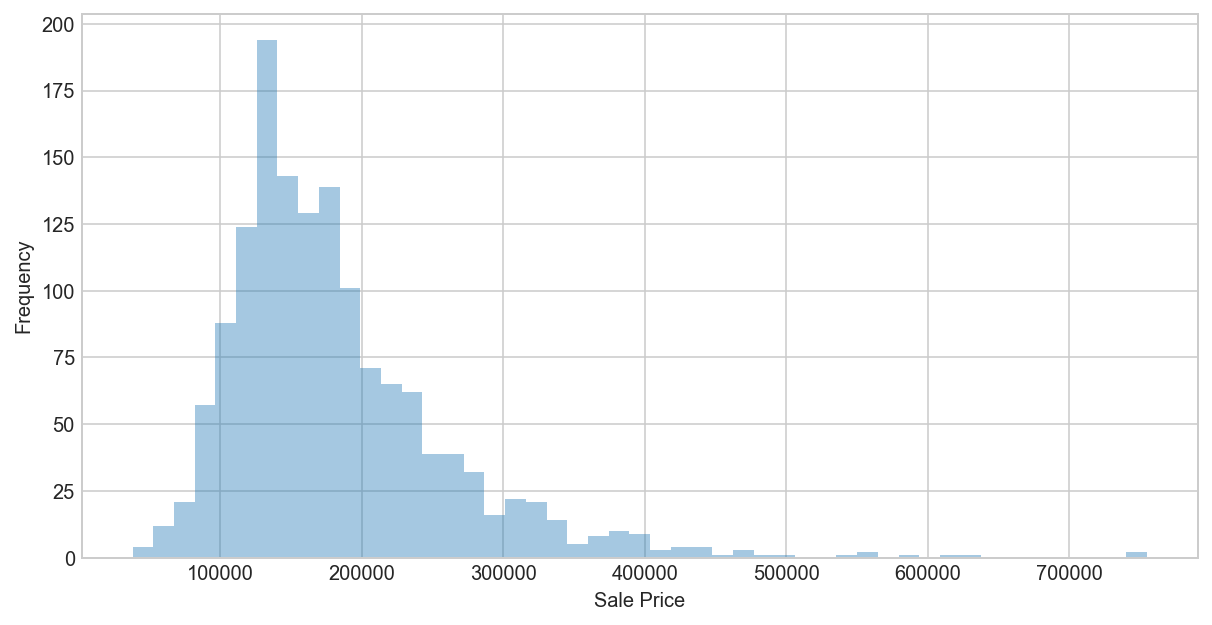

In [9]:
(fig, ax) = plt.subplots(figsize=(10, 5))
ax = sns.distplot(residential.SalePrice, kde=False, ax=ax)
ax.set(xlabel='Sale Price', ylabel='Frequency')
plt.show()

In [10]:
# Let's look at the header
residential.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
residential.Condition1.value_counts()

Norm      1252
Feedr       79
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Note the presence of _NaNs_ in several columns including:

1. Alley
2. PoolQC
3. Fence
4. MiscFeature

Let's get a count of how many columns have missing values in them.

In [12]:
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-

## Feature Engineering

Reading through **data_description.txt** several columns use **NA** to represent the absence of a specific building feature as opposed to missing values:

    1. Alley - NA: No alley access
    2. BsmtQual - NA: No basement
    3. BsmtCond - NA: No basement
    4. BsmtExposure - NA: No basement
    5. BsmtFinType1 - NA: No basement
    6. BsmtFinType2 - NA: No basement
    7. FireplaceQu - NA: No fireplace
    8. GarageQual - NA: No garage
    9. GarageType - NA: No garage
    10. GarageFinish - NA: No garage
    11. GarageCond - NA: No garage
    12. PoolQC - NA: No pool
    13. Fence - NA: No fence
    14. MiscFeature - NA: No extra features

In [13]:
residential.Alley = residential.Alley.fillna(value='None')
residential.BsmtQual = residential.BsmtQual.fillna(value='None')
residential.BsmtCond = residential.BsmtCond.fillna(value='None')
residential.BsmtExposure = residential.BsmtQual.fillna(value='None')
residential.BsmtFinType1 = residential.BsmtFinType1.fillna(value='None')
residential.BsmtFinType2 = residential.BsmtFinType2.fillna(value='None')
residential.FireplaceQu = residential.FireplaceQu.fillna(value='None')
residential.GarageCond = residential.GarageCond.fillna(value='None')
residential.GarageFinish = residential.GarageFinish.fillna(value='None')
residential.GarageQual = residential.GarageQual.fillna(value='None')
residential.GarageType = residential.GarageType.fillna(value='None')
residential.Fence = residential.Fence.fillna(value='None')
residential.MiscFeature = residential.MiscFeature.fillna(value='None')
residential.PoolQC = residential.PoolQC.fillna(value='None')

In [14]:
residential.Alley.value_counts()

None    1361
Grvl      50
Pave      39
Name: Alley, dtype: int64

In [15]:
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 no

We have 1450 observations in total. We could drop observations from _Electrical_, _GarageYrBlt_, _LotFrontage_, _MsVnrType_ and _MasVnrArea_ as they contain NaNs, but let's think about how we might be able to impute these values instead.

#### Fixing 1 Null in Electrical

In [16]:
residential.Electrical.value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [17]:
residential.loc[residential.Electrical.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,None,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,167500


In [18]:
# Going to play the numbers game and set this to SBrkr
residential.loc[residential.Electrical.isnull(),'Electrical'] = 'SBrkr'

#### Fixing GarageYrBuilt

In [19]:
# What is the sum of the Garage Areas for all entries where we don't have a Garage Year Built?
residential2 = residential.copy()
residential2[residential2.GarageYrBlt.isnull()]['GarageArea'].sum()

0

These NaNs make sense. If a house doesn't have a garage, then we don't have a year that the garage was built. So let's assign these NaNs, to the variable _YearBuilt_, the year the house was built.

In [20]:
residential2.loc[residential2.GarageYrBlt.isnull(), 'GarageYrBlt'] = \
residential2.loc[residential2.GarageYrBlt.isnull(), 'YearBuilt']

In [21]:
residential2.GarageYrBlt.astype(int)
residential2.GarageYrBlt.isnull().any()

False

#### Fixing LotFrontage

_LotFrontage_ refers to the linear feet of street connected to a property. There should be some relationship between _LotArea_ (which had no nulls in our residential dataset) and LotFrontage. We could look at the ratio between the two but let's think of something even simpler. Assume that every property in our dataset is a square of area **x^2**. Then the perimter of the plot would be **4x**. Since only one side faces the street, _LotFrontage_ = **x** or _LotFrontage_ = sqrt(_LotArea_).

In [22]:
residential2.loc[residential2.LotFrontage.isnull(),'LotFrontage'] = \
np.sqrt(residential2.loc[residential2.LotFrontage.isnull()]['LotArea'])

In [23]:
residential2.LotFrontage.isnull().any()

False

In [24]:
residential2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 no

#### Fixing MasVnrType and MasVnrArea

In [25]:
residential2.MasVnrType.value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Note that where information is missing for _MasVnrType_ it is missing for _MasVnrArea_.

In [26]:
residential2[residential2.MasVnrType.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,60,RL,88.605869,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500
529,20,RL,180.742911,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,TA,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624
650,60,FV,65.000000,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950
936,20,RL,67.000000,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900
973,20,FV,95.000000,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000
977,120,FV,35.000000,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900
1243,20,RL,107.000000,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Ex,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000
1278,60,RL,75.000000,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000


_MasVnrType_ would depend on the type of dwelling, neighborhood, housetype and zoning area. We assume that whatever the most popular _MasVnrType_ is in a particular neighborhood, would be available in the missing 8.

In [27]:
PopVeneerType = residential2.groupby(['MSSubClass','MSZoning','Neighborhood','BldgType','HouseStyle'])\
['MasVnrType'].agg(lambda x: x.value_counts().index[0]).reset_index()
PopVeneerType.rename(columns={'MasVnrType':'MostCommonVnrType'}, inplace=True)

Let's merge these two dataframes to get the appropriate MasVnrType for each of the 8 missing houses.

In [28]:
residential3 = pd.merge(residential2, PopVeneerType, \
                        on=['MSSubClass','MSZoning','Neighborhood','BldgType','HouseStyle'],how='inner')
residential3[residential3.MasVnrType.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MostCommonVnrType
44,60,RL,75.000000,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000,None
494,20,RL,67.000000,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900,None
535,20,RL,107.000000,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Ex,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000,BrkFace
600,20,FV,95.000000,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000,None
617,60,RL,88.605869,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500,None
960,60,FV,65.000000,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950,None
1000,20,RL,180.742911,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,TA,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624,BrkFace
1382,120,FV,35.000000,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900,None


In [29]:
residential3.loc[residential3.MasVnrType.isnull(), 'MasVnrType'] = \
residential3.loc[residential3.MasVnrType.isnull(), 'MostCommonVnrType']

In [30]:
residential3.MasVnrType.isnull().any()

False

In [31]:
residential3.drop('MostCommonVnrType',axis=1, inplace=True)

In [32]:
PopVeneerArea = residential3.groupby(['MSSubClass','MSZoning','Neighborhood','BldgType','HouseStyle'])\
['MasVnrArea'].mean().reset_index()
PopVeneerArea.rename(columns={'MasVnrArea':'PopVnrArea'}, inplace=True)
PopVeneerArea.head()

,MSSubClass,MSZoning,Neighborhood,BldgType,HouseStyle,PopVnrArea
0,20,FV,Somerst,1Fam,1Story,64.166667
1,20,RH,SawyerW,1Fam,1Story,0.000000
2,20,RL,Blmngtn,1Fam,1Story,16.000000
3,20,RL,BrkSide,1Fam,1Story,0.000000
4,20,RL,ClearCr,1Fam,1Story,121.500000


In [33]:
residential4 = pd.merge(residential3, PopVeneerArea, \
                        on=['MSSubClass','MSZoning','Neighborhood','BldgType','HouseStyle'],how='inner')
residential4[residential4.MasVnrArea.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PopVnrArea
44,60,RL,75.000000,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000,100.038462
494,20,RL,67.000000,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900,83.933333
535,20,RL,107.000000,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,NaN,Ex,TA,PConc,Ex,Gd,Ex,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000,347.903226
600,20,FV,95.000000,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000,64.166667
617,60,RL,88.605869,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500,42.355932
960,60,FV,65.000000,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950,118.250000
1000,20,RL,180.742911,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,BrkFace,NaN,Gd,TA,PConc,TA,TA,TA,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624,139.300000
1382,120,FV,35.000000,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,Gd,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900,15.000000


In [34]:
residential4.loc[residential4.MasVnrArea.isnull(), 'MasVnrArea'] = \
residential4.loc[residential4.MasVnrArea.isnull(), 'PopVnrArea']
residential4.MasVnrArea.isnull().any()

False

In [35]:
residential4.drop('PopVnrArea',axis=1,inplace=True)

#### Features with limited predictive power

**Note:** Let's drop a column if it's missing > 50% of all observations (1450) as these potential features will have limited predictive power.

In [36]:
half_count = len(residential4)/2
residential4 = residential4.reset_index().dropna(thresh=half_count, axis=1)
residential4.drop('index', axis=1, inplace=True)
residential4.shape

(1450, 80)

** No columns dropped **

In [37]:
residential4.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

**Note:** Change column names for 1stFlrSF, 2ndFlrSF, 3SsnPortch to _FirstFlrSF_, _SecondFlrSF_ and _ThreeSsnPorch_ to conform to Python PEP 8 naming conventions.

In [38]:
residential4.rename(columns = {'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF', '3SsnPorch':'ThreeSsnPorch'}, 
                    inplace = True)

In [39]:
residential4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,60,RL,68.000000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
2,60,RL,89.000000,11645,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,860,860,GasA,Ex,Y,SBrkr,860,860,0,1720,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2004.0,RFn,2,565,TA,TA,Y,0,70,0,0,0,0,None,None,None,0,8,2006,WD,Normal,196500
3,60,RL,96.824584,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,Gd,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,None,GdPrv,None,0,2,2009,WD,Normal,219500
4,60,RL,69.000000,9337,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,PConc,Gd,TA,Gd,GLQ,648,Unf,0,176,824,GasA,Ex,Y,SBrkr,905,881,0,1786,1,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,1997.0,RFn,2,684,TA,TA,Y,0,162,0,0,0,0,None,None,None,0,5,2007,WD,Normal,204750


### Not Bedrooms, Bathrooms or Kitchens

We have a variable called **TotRmsAbvGrd** which captures overlapping information to _BedroomAbvGr_, _KitchenAbvGr_, _HalfBath_ and _FullBath_ . We define a new feature called **Rm_Not_Bd_Bath_K** = _TotRmsAbvGrd - (FullBath+HalfBath+BedroomAbvGr+KitchenAbvGr)_. If the value of this variable < 0 we set it equal to zero.

In [40]:
residential4['Rm_Not_Bd_Bath_K'] = \
residential4.TotRmsAbvGrd - (residential4.BedroomAbvGr+residential4.KitchenAbvGr\
                             +residential4.FullBath+residential4.HalfBath)
residential4.loc[residential4['Rm_Not_Bd_Bath_K'] < 0, 'Rm_Not_Bd_Bath_K'] = 0
residential4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Rm_Not_Bd_Bath_K
0,60,RL,65.000000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1
1,60,RL,68.000000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0
2,60,RL,89.000000,11645,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,860,860,GasA,Ex,Y,SBrkr,860,860,0,1720,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2004.0,RFn,2,565,TA,TA,Y,0,70,0,0,0,0,None,None,None,0,8,2006,WD,Normal,196500,0
3,60,RL,96.824584,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,Gd,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,None,GdPrv,None,0,2,2009,WD,Normal,219500,1
4,60,RL,69.000000,9337,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,PConc,Gd,TA,Gd,GLQ,648,Unf,0,176,824,GasA,Ex,Y,SBrkr,905,881,0,1786,1,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,1997.0,RFn,2,684,TA,TA,Y,0,162,0,0,0,0,None,None,None,0,5,2007,WD,Normal,204750,0


In [41]:
residential4.Rm_Not_Bd_Bath_K.value_counts()

0    692
1    514
2    182
3     48
5      7
4      7
Name: Rm_Not_Bd_Bath_K, dtype: int64

### Yard Area

The yard area could affect the Sale Price of a house.

In [42]:
# Yard area = LotArea - Indoor Area - Porch Area.

porch_area = residential4["WoodDeckSF"] + residential4["OpenPorchSF"] + residential4["EnclosedPorch"] + \
            residential4["ThreeSsnPorch"] + residential4["ScreenPorch"]

residential4["Yard_Area"] = residential4["LotArea"] - (residential4["GrLivArea"] + porch_area)

### Bathroom/Bedroom Area

The bathroom to bedroom ratio could affect the Sale Price of the house.

In [43]:
# Bathroom to Bedroom Ratio may also affect Sale Price
residential4["Bath_to_Bed_ratio"] = (residential4["BsmtFullBath"] + residential4["BsmtHalfBath"] + \
                                     residential4["FullBath"] + residential4["HalfBath"])/residential4["BedroomAbvGr"]

In [44]:
residential4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Rm_Not_Bd_Bath_K,Yard_Area,Bath_to_Bed_ratio
0,60,RL,65.000000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1,6679,1.333333
1,60,RL,68.000000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,9422,1.333333
2,60,RL,89.000000,11645,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,860,860,GasA,Ex,Y,SBrkr,860,860,0,1720,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2004.0,RFn,2,565,TA,TA,Y,0,70,0,0,0,0,None,None,None,0,8,2006,WD,Normal,196500,0,9855,1.000000
3,60,RL,96.824584,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,Gd,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,None,GdPrv,None,0,2,2009,WD,Normal,219500,1,6729,1.333333
4,60,RL,69.000000,9337,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,PConc,Gd,TA,Gd,GLQ,648,Unf,0,176,824,GasA,Ex,Y,SBrkr,905,881,0,1786,1,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,1997.0,RFn,2,684,TA,TA,Y,0,162,0,0,0,0,None,None,None,0,5,2007,WD,Normal,204750,0,7389,1.333333


### Basement Quality

Basement quality refers to the height of the basement! It's a fixed feature and we can create a dictionary to properly describe this feature:

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [45]:
# Using the lower height for each group here...
bsmt_qual = {'None':0, 'Po':60, 'Fa':70, 'TA':80, 'Gd':90, 'Ex':100}

In [46]:
residential4['BsmtQual'] = residential4['BsmtQual'].map(lambda x: bsmt_qual[x])
residential4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Rm_Not_Bd_Bath_K,Yard_Area,Bath_to_Bed_ratio
0,60,RL,65.000000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,90,TA,Gd,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1,6679,1.333333
1,60,RL,68.000000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,90,TA,Gd,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,9422,1.333333
2,60,RL,89.000000,11645,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,90,TA,Gd,Unf,0,Unf,0,860,860,GasA,Ex,Y,SBrkr,860,860,0,1720,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2004.0,RFn,2,565,TA,TA,Y,0,70,0,0,0,0,None,None,None,0,8,2006,WD,Normal,196500,0,9855,1.000000
3,60,RL,96.824584,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,90,TA,Gd,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,None,GdPrv,None,0,2,2009,WD,Normal,219500,1,6729,1.333333
4,60,RL,69.000000,9337,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,PConc,90,TA,Gd,GLQ,648,Unf,0,176,824,GasA,Ex,Y,SBrkr,905,881,0,1786,1,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,1997.0,RFn,2,684,TA,TA,Y,0,162,0,0,0,0,None,None,None,0,5,2007,WD,Normal,204750,0,7389,1.333333


## Baseline Model

Let's establish a baseline model we hope to eclipse with our actual/refined model.

In [47]:
features = residential4.drop(['SaleCondition','SalePrice'], axis=1)
target = residential4.SalePrice

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
# This line of code errors out as Python is confused by the value of 'Normal' as one of the variable names
#(X_train, X_test, y_train, y_test) = train_test_split(features, target)
(X_train, X_test, y_train, y_test) = train_test_split(features[['GrLivArea']], target)
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0012880285536851499

***The bar has been set very very low, indeed.***

# Fixed Model Construction

A fixed model uses only those features of a house which **cannot** be altered/renovated.

## Approach 1: Identify regressors by ranking potential features with correlation to Sale Price

In [49]:
def RankedCorrMat(df, var_of_interest):
    # Calculate the correlation matrix of the entire dataframe
    corrmat = df.corr()
    # Melt a wide correlation matrix into long format
    melted = corrmat.reset_index().melt(id_vars='index')
    # Filter on variable of interest
    spcorr = melted[melted.variable == var_of_interest]
    # Drop NaNs
    spcorr = spcorr.dropna()
    # Sort from Highest to Lowest Correlation
    spcorranked = spcorr.sort_values('value', ascending=False)
    return spcorranked

In [50]:
residential_saleprice_corr = RankedCorrMat(residential4, 'SalePrice')
residential_saleprice_corr

,index,variable,value
1554,SalePrice,SalePrice,1.000000
1520,OverallQual,SalePrice,0.789031
1533,GrLivArea,SalePrice,0.708658
1543,GarageCars,SalePrice,0.642135
1544,GarageArea,SalePrice,0.629831
1529,TotalBsmtSF,SalePrice,0.612088
1530,FirstFlrSF,SalePrice,0.603300
1536,FullBath,SalePrice,0.556674
1540,TotRmsAbvGrd,SalePrice,0.533355
1522,YearBuilt,SalePrice,0.517602


Several features correlate positively with Sale Price. Let's split them up into continuous, discrete & categorical variables:

_Continuous_
    1. GrLivArea: Above grade (ground) living area in sqft
    2. GarageArea: Size of garage in square feet
    3. TotalBsmtSF: Total basement area in square feet
    4. FirstFlrSF: First Floor square feet
    5. YearBuilt: Original construction date
    6. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    7. GarageYrBlt: Year Garage was built
    8. MasVnrArea: Masonry veneer area in square feet
    9. Bath_to_Bed Ratio
    10. BsmtFinSF1: Basement finished area in sqft
    11. LotFrontage: Linear ft of street connected to property
    12. OpenPorchSF: Open porch area in sqft
    13. WoodDeckSF: Wood Deck area in sqft
    14. SecondFlrSF: Second Floor in sqft
    15. LotArea: Size in sqft
    16. Yard_Area: Lot Area - Ground Floor Area
    17. BsmtUnfSF: Unfinished sqft of basement area
    18. ScreenPorch: Screen porch area in sqft
    19. PoolArea: Pool area in sqft
    20. ThreeSsnPorch: Three season porch area in sqft
    
_Discrete_
    1. Overall Quality
    2. Overall Condition
    3. GarageCars: Size of garage in car capacity
    4. FullBath: Full bathrooms above grade in sqft
    5. TotRmsAbvGrd: Total rooms above grade (not including bathrooms)
    6. Fireplaces: Number of Fireplaces
    7. Rm_Not_Bd_Bath_K
    8. HalfBath: Half baths above grade
    9. BsmtFullBath: Full bathrooms above grade
    10. BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
    11. Basement Quality
    12. MoSold

_Categorical_
    1. Neighborhood
    2. LotShape
    3. LotConfig
    4. LandSlope
    5. Condition1
    6. Condition2
    7. BldgType
    8. HouseStyle
    9. Foundation

***OverallQual*** and ***OverallCond*** while quality type variables, cannot be changed without exhaustive renovations and we classify them as 'Fixed' discrete variables.

### Controlling for multicollinearity and extraneous variables

If we naively built a model combining all 41 features we risk introducing multicollinearity as certain variables e.g. GarageCars & Garage Area are highly correlated; and features such as YearBuilt and YearRemodAdd contain the same information. We choose to: 
    1. Drop GarageCars in favor of the continuous variable GarageArea.
    2. Use YearRemodAdd only as it encapsulates YearBuilt.
    3. Drop LotArea which is equal to Yard_Area + GrLivArea + PorchArea.
    4. Drop TotRmsAbvGrd in favor of number of bedrooms, num kitchens, num bathrooms, remaining rooms.
    5. Drop FirstFlrSF and SecondFlrSF as we capture that data with GrLivArea.

### Fixed Model, continuous features:

In [51]:
target = residential4[['SalePrice']]
features_c = residential4[['GrLivArea','GarageArea','TotalBsmtSF','YearRemodAdd','GarageYrBlt',
                          'MasVnrArea','BsmtFinSF1','LotFrontage','OpenPorchSF','WoodDeckSF',
                          'Yard_Area','BsmtUnfSF','ScreenPorch','PoolArea','ThreeSsnPorch']]

In [52]:
features_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 15 columns):
GrLivArea        1450 non-null int64
GarageArea       1450 non-null int64
TotalBsmtSF      1450 non-null int64
YearRemodAdd     1450 non-null int64
GarageYrBlt      1450 non-null float64
MasVnrArea       1450 non-null float64
BsmtFinSF1       1450 non-null int64
LotFrontage      1450 non-null float64
OpenPorchSF      1450 non-null int64
WoodDeckSF       1450 non-null int64
Yard_Area        1450 non-null int64
BsmtUnfSF        1450 non-null int64
ScreenPorch      1450 non-null int64
PoolArea         1450 non-null int64
ThreeSsnPorch    1450 non-null int64
dtypes: float64(3), int64(12)
memory usage: 170.0 KB


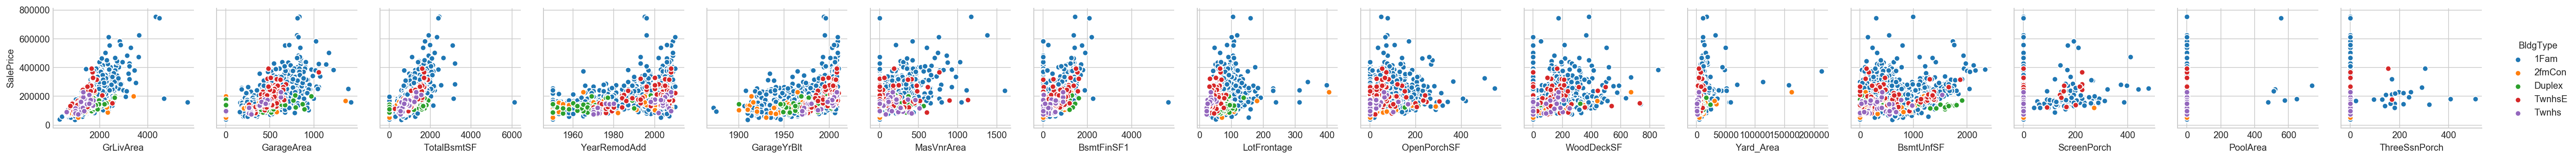

In [53]:
sns.pairplot(data=residential4, y_vars=target.columns, x_vars=features_c.columns, hue='BldgType')
plt.show()

Visualization confirms what the correlation matrix reveals. We can drop some of the weaker continuous features:
1. ThreeSsnPorch
2. PoolArea
3. ScreenPorch

In [54]:
features_c_refined = features_c.drop(['ScreenPorch','PoolArea','ThreeSsnPorch'],axis=1)
features_c_refined.head()

,GrLivArea,GarageArea,TotalBsmtSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,Yard_Area,BsmtUnfSF
0,1710,548,856,2003,2003.0,196.0,706,65.000000,61,0,6679,150
1,1786,608,920,2002,2001.0,162.0,486,68.000000,42,0,9422,434
2,1720,565,860,2004,2004.0,0.0,0,89.000000,70,0,9855,860
3,2034,645,1057,1998,1998.0,573.0,739,96.824584,36,576,6729,318
4,1786,684,824,1997,1997.0,0.0,648,69.000000,162,0,7389,176


### Fixed Model, discrete features:

In [55]:
features_d = residential4[['OverallQual','OverallCond','FullBath','Rm_Not_Bd_Bath_K','BsmtQual',
                           'Fireplaces','HalfBath','BsmtFullBath','BedroomAbvGr']]

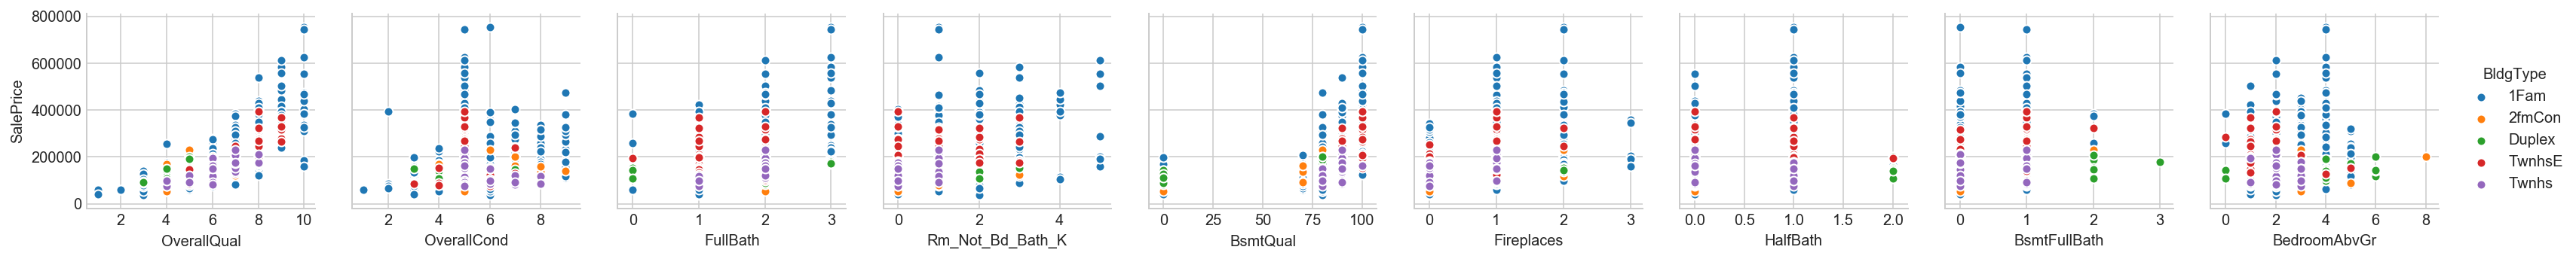

In [56]:
sns.pairplot(data=residential4, y_vars=target.columns, x_vars=features_d.columns, hue='BldgType')
plt.show()

A fewer of the discrete variables appear to have limited predictive power. We drop these weaker features, including:
1. HalfBath
2. BsmtFullBath
3. BedroomAbvGr

In [57]:
features_d_refined = features_d.drop(['HalfBath','BsmtFullBath','BedroomAbvGr'],axis=1)
features_d_refined.head()

,OverallQual,OverallCond,FullBath,Rm_Not_Bd_Bath_K,BsmtQual,Fireplaces
0,7,5,2,1,90,0
1,7,5,2,0,90,1
2,7,5,2,0,90,0
3,7,5,2,1,90,0
4,6,5,2,0,90,0


In [58]:
features_d_refined.dtypes

OverallQual         int64
OverallCond         int64
FullBath            int64
Rm_Not_Bd_Bath_K    int64
BsmtQual            int64
Fireplaces          int64
dtype: object

### Fixed Model, Categorical features:

In [59]:
target = residential4[['SalePrice']]
features_cat = residential4[['Neighborhood','LotShape','LotConfig','LandSlope','Condition1',
                          'Condition2','BldgType','HouseStyle','Foundation']]

In [60]:
# Convert to dummy regressors.
features_cat_dummy = pd.get_dummies(features_cat[['Neighborhood','LotShape','LotConfig','LandSlope','Condition1',
                          'Condition2','BldgType','HouseStyle','Foundation']])
features_cat_dummy.shape

(1450, 73)

In [61]:
features_cat_dummy.tail()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
1445,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1447,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1448,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1449,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [62]:
# Add target variable back in
categorical = pd.concat([features_cat_dummy, target.reset_index()], axis=1)
categorical.drop('index',axis=1,inplace=True)
categorical.tail()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SalePrice
1445,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,79000
1446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,197000
1447,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,191000
1448,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,121000
1449,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,112000


In [63]:
categorical.corr('pearson').SalePrice.sort_values(ascending=False).head(10)

SalePrice               1.000000
Foundation_PConc        0.494186
Neighborhood_NridgHt    0.402772
Neighborhood_NoRidge    0.331128
HouseStyle_2Story       0.241565
LotShape_IR1            0.220529
Neighborhood_StoneBr    0.215616
BldgType_1Fam           0.141761
LotConfig_CulDSac       0.140377
Neighborhood_Somerst    0.138715
Name: SalePrice, dtype: float64

Let's pick Categorical variables whose correlation with SalePrice > 0.2 here for our final categorical variables.

In [64]:
features_cat_refined = categorical[['Foundation_PConc', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge',\
                                      'HouseStyle_2Story','Neighborhood_StoneBr']]

### Isolate target variable and year sold

In [65]:
target = residential4.SalePrice
YearSold = residential4.YrSold

### Standardization:

Let's combine all regressors together and scale all these features.

In [66]:
# continuous
features_c_refined.shape

(1450, 12)

In [67]:
# discrete
features_d_refined.shape

(1450, 6)

In [68]:
# categorical
features_cat_refined.shape

(1450, 5)

In [69]:
X = pd.concat([features_c_refined, features_d_refined.reset_index(), features_cat_refined.reset_index()], axis=1)
X.tail()

,GrLivArea,GarageArea,TotalBsmtSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,Yard_Area,BsmtUnfSF,index,OverallQual,OverallCond,FullBath,Rm_Not_Bd_Bath_K,BsmtQual,Fireplaces,index,Foundation_PConc,Neighborhood_NridgHt,Neighborhood_NoRidge,HouseStyle_2Story,Neighborhood_StoneBr
1445,774,0,544,2006,1931.0,0.0,544,70.000000,0,0,3210,0,1445,3,6,1,1,80,0,1445,0,0,0,0,0
1446,1725,550,539,1979,1979.0,96.0,315,80.000000,88,0,9555,114,1446,7,6,2,0,80,1,1446,0,0,0,0,0
1447,2555,672,588,1994,1993.0,0.0,0,79.000000,0,431,8540,588,1447,6,7,2,5,100,1,1447,0,0,0,0,0
1448,952,192,952,1950,1916.0,0.0,0,94.095696,98,0,7764,952,1448,6,6,1,0,80,1,1448,0,0,0,0,0
1449,1346,384,560,2000,1950.0,0.0,0,70.000000,24,168,10229,560,1449,4,7,1,1,70,0,1449,0,0,0,1,0


In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.25923135,  0.3864598 ,  0.1400982 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.27354936,  0.42877292,  0.15057283, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.2611153 ,  0.39844852,  0.14075286, ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 0.41842502,  0.47390691,  0.09623568, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11642803,  0.13540197,  0.15581015, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19065561,  0.27080395,  0.09165303, ...,  0.        ,
         1.        ,  0.        ]])

In [71]:
scaled_features = pd.DataFrame(X_scaled, columns=X.columns)
scaled_features.head()

,GrLivArea,GarageArea,TotalBsmtSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,Yard_Area,BsmtUnfSF,index,OverallQual,OverallCond,FullBath,Rm_Not_Bd_Bath_K,BsmtQual,Fireplaces,index,Foundation_PConc,Neighborhood_NridgHt,Neighborhood_NoRidge,HouseStyle_2Story,Neighborhood_StoneBr
0,0.259231,0.386460,0.140098,0.883333,0.949275,0.122500,0.125089,0.114350,0.111517,0.000000,0.031685,0.064212,0.000000,0.666667,0.5,0.666667,0.2,0.9,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0
1,0.273549,0.428773,0.150573,0.866667,0.934783,0.101250,0.086109,0.122147,0.076782,0.000000,0.044545,0.185788,0.000690,0.666667,0.5,0.666667,0.0,0.9,0.333333,0.000690,1.0,0.0,0.0,1.0,0.0
2,0.261115,0.398449,0.140753,0.900000,0.956522,0.000000,0.000000,0.176723,0.127971,0.000000,0.046576,0.368151,0.001380,0.666667,0.5,0.666667,0.0,0.9,0.000000,0.001380,1.0,0.0,0.0,1.0,0.0
3,0.320271,0.454866,0.172995,0.800000,0.913043,0.358125,0.130936,0.197058,0.065814,0.672112,0.031919,0.136130,0.002070,0.666667,0.5,0.666667,0.2,0.9,0.000000,0.002070,1.0,0.0,0.0,1.0,0.0
4,0.273549,0.482370,0.134861,0.783333,0.905797,0.000000,0.114812,0.124746,0.296161,0.000000,0.035014,0.075342,0.002761,0.555556,0.5,0.666667,0.0,0.9,0.000000,0.002761,1.0,0.0,0.0,1.0,0.0


In [72]:
# Combining all features together
df = pd.concat([scaled_features, residential4.YrSold.reset_index(), target.reset_index()], axis=1)
df.drop('index',axis=1,inplace=True)
df.tail()

,GrLivArea,GarageArea,TotalBsmtSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,Yard_Area,BsmtUnfSF,OverallQual,OverallCond,FullBath,Rm_Not_Bd_Bath_K,BsmtQual,Fireplaces,Foundation_PConc,Neighborhood_NridgHt,Neighborhood_NoRidge,HouseStyle_2Story,Neighborhood_StoneBr,YrSold,SalePrice
1445,0.082894,0.000000,0.089034,0.933333,0.427536,0.00,0.096386,0.127344,0.000000,0.000000,0.015420,0.000000,0.222222,0.625,0.333333,0.2,0.8,0.000000,0.0,0.0,0.0,0.0,0.0,2007,79000
1446,0.262057,0.387870,0.088216,0.483333,0.775362,0.06,0.055811,0.153333,0.160878,0.000000,0.045169,0.048801,0.666667,0.625,0.666667,0.0,0.8,0.333333,0.0,0.0,0.0,0.0,0.0,2007,197000
1447,0.418425,0.473907,0.096236,0.733333,0.876812,0.00,0.000000,0.150734,0.000000,0.502917,0.040410,0.251712,0.555556,0.750,0.666667,1.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,2008,191000
1448,0.116428,0.135402,0.155810,0.000000,0.318841,0.00,0.000000,0.189966,0.179159,0.000000,0.036772,0.407534,0.555556,0.625,0.333333,0.0,0.8,0.333333,0.0,0.0,0.0,0.0,0.0,2009,121000
1449,0.190656,0.270804,0.091653,0.833333,0.565217,0.00,0.000000,0.127344,0.043876,0.196033,0.048329,0.239726,0.333333,0.750,0.333333,0.2,0.7,0.000000,0.0,0.0,0.0,1.0,0.0,2007,112000


### Fixed Model Testing:

Training dataset are houses sold before 2010 while testing dataset are houses sold in 2010.

In [73]:
# Create train subset
train = df[df.YrSold < 2010]
# Create X_train and y_train sets
X_train = train.drop(['SalePrice','YrSold'], axis=1)
y_train = train[['SalePrice']]
# Create test subset
test = df[df.YrSold == 2010]
# Create X_test and y_test sets
X_test = test.drop(['SalePrice','YrSold'], axis=1)
y_test = test[["SalePrice"]]

In [74]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()
ts = TheilSenRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
huber.fit(X_train, y_train)

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [76]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [77]:
ts.fit(X_train, y_train)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [78]:
# Print R_squared
print "The R-squared of the RANSAC Fixed characteristics housing model is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber Fixed characteristics housing model is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS Fixed characteristics housing model is: ", ols.score(X_test, y_test)
print "The R-squared of the Theil-Sen Fixed characteristics housing model is: ", ts.score(X_test, y_test)

The R-squared of the RANSAC Fixed characteristics housing model is:  0.809287127882
The R-squared of the Huber Fixed characteristics housing model is:  0.823876766692
The R-squared of the OLS Fixed characteristics housing model is:  0.826514546592
The R-squared of the Theil-Sen Fixed characteristics housing model is:  0.838880882041


Interesting that the R-square of Theil-Sen is higher than that of OLS! Theil-Sen  explains up to 83.4% of the variance in the residuals of regressing fixed features against the Sale Price in the test set! For lower priced houses we do a fairly good job at predicting the target, but outliers in the Sale Price affect our predictions for the most expensive properties. 

The outperformance of Theil-Sen makes sense as our Sale Price data contains a few Y outliers (high priced outliers) which the model doesn't overfit to.

***To be really confident we could cross validate our sample over k folds, but we're restricted here by the training set being pre-2010 sales and the test set being 2010 sales.***

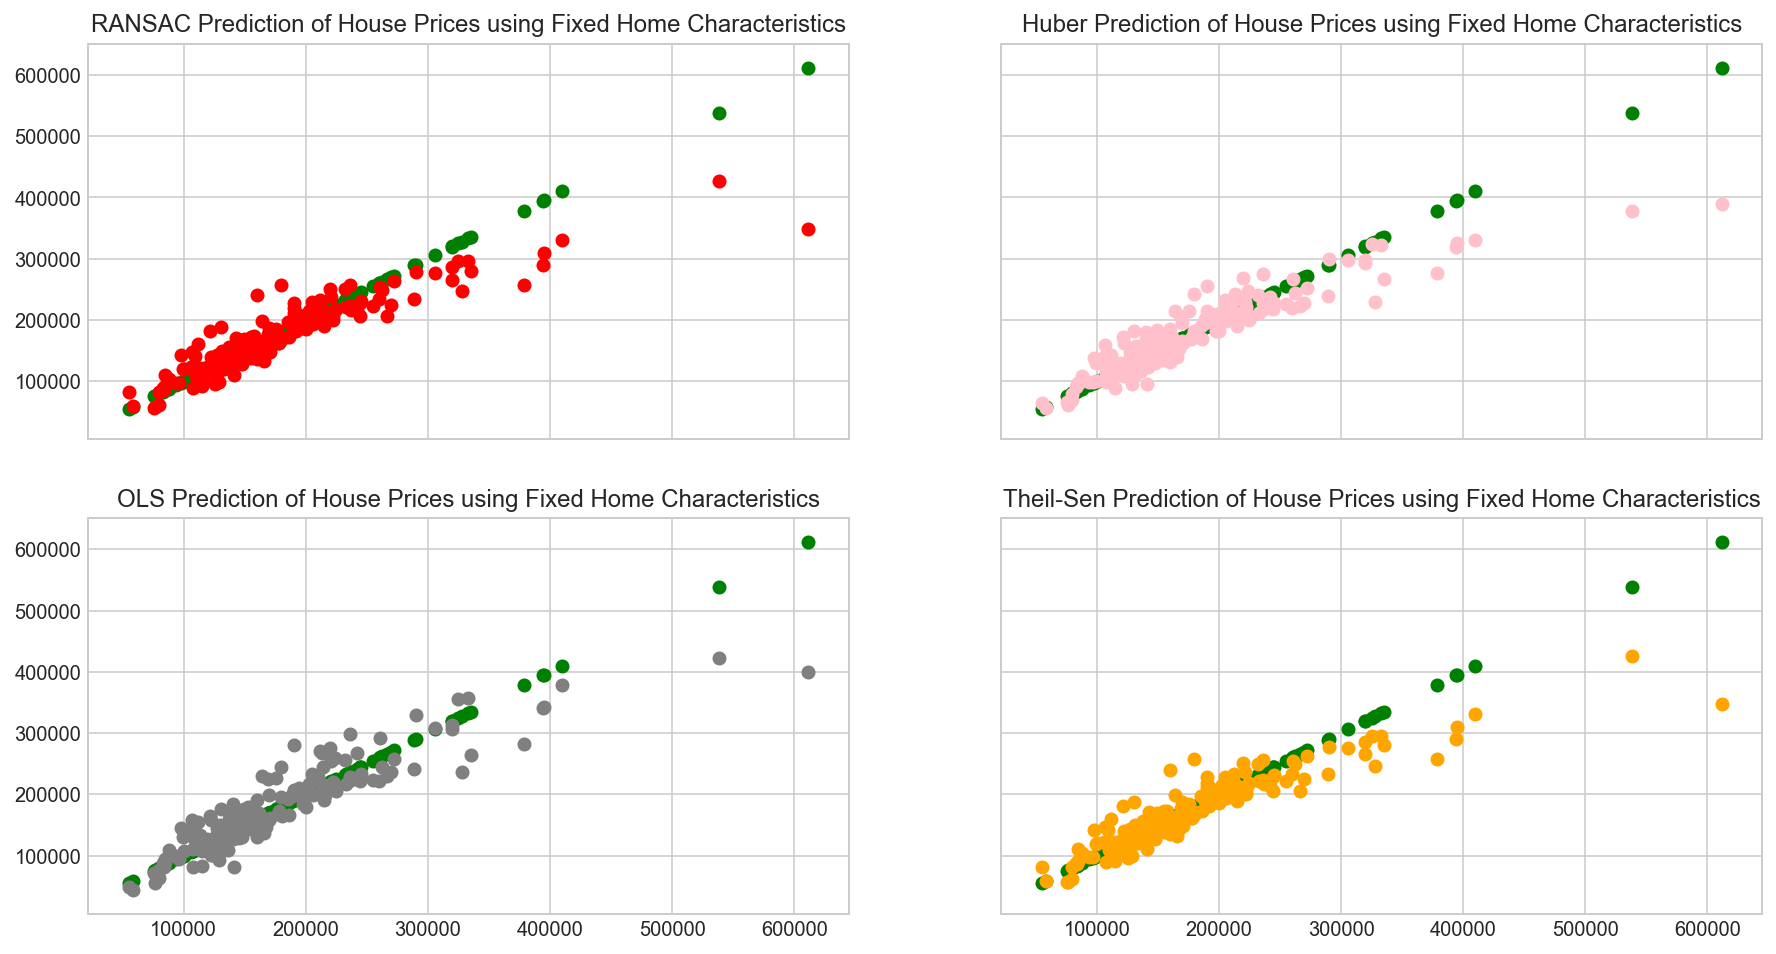

In [79]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)
ypred_ts = ts.predict(X_test)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,8))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of House Prices using Fixed Home Characteristics')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of House Prices using Fixed Home Characteristics')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of House Prices using Fixed Home Characteristics')
ax4.scatter(y_test, y_test, c='green')
ax4.scatter(y_test, ypred_r, c='orange')
ax4.set_title('Theil-Sen Prediction of House Prices using Fixed Home Characteristics')
plt.show()

R-squared is not the only metric by which we should judge how good our model is. Another approach is to determine how far off our prediction was from the actual sale price of the house.

In [80]:
# Median Absolute Error
from sklearn.metrics import median_absolute_error, r2_score
print "Using OLS Regression on average our estimate of house prices misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of house prices misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of house prices misses by", \
median_absolute_error(huber.predict(X_test), y_test)
print "Using Theil-Sen Regression on average our estimate of house prices misses by", \
median_absolute_error(ts.predict(X_test), y_test)

Using OLS Regression on average our estimate of house prices misses by 16206.5188128
Using RANSAC Regression on average our estimate of house prices misses by 13376.0867583
Using Huber Regression on average our estimate of house prices misses by 13546.9364521
Using Theil-Sen Regression on average our estimate of house prices misses by 12542.607538


Using the median absolute error score to rank our models taking an average across 4 cross folds, the Theil-Sen model continues to perform well, providing us with the closest estimation of sale price as it is not affected by outliers along the y-axis (Sale Price).

### Approach 2: Regularization to identify features of interest

In [81]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
alpha_list = np.linspace(0.1,1,100)
l1_ratios = np.linspace(0.1,1,100)
elastic_cv = ElasticNetCV(alphas=alpha_list,l1_ratio=l1_ratios)
# Do we really cross-validate across the training set?
elastic_cv.fit(X_train, y_train)

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(alphas=array([ 0.1    ,  0.10909, ...,  0.99091,  1.     ]),
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.1    ,  0.10909, ...,  0.99091,  1.     ]),
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [82]:
elastic_cv.alpha_

0.1090909090909091

In [83]:
elastic_cv.l1_ratio_

0.96363636363636362

In [84]:
elastic_cv.score(X_test, y_test)

0.8152792910419675

#### Note to self - this is identical to:

In [85]:
elastic = ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.1090909090909091, copy_X=True, fit_intercept=True,
      l1_ratio=0.96363636363636362, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
elastic.score(X_test, y_test)

0.8152792910419675

In [87]:
# Or equivalently...
y_pred_elastic = elastic.fit(X_train, y_train).predict(X_test)
r2_score_elastic = r2_score(y_test, y_pred_elastic)
r2_score_elastic

0.8152792910419675

In [88]:
# How do we fare on Greg's favorite metric?
median_absolute_error(y_test, y_pred_elastic)

17105.230146215326

#### We're still outperformed by the Theil-Sen regressor here which had a higher R-squared and a lower median absolute error.

In [89]:
# From the cross-validation above
elastic_cv.l1_ratio_

0.96363636363636362

Our l1 ratio is close to 1 so let's try a **Lasso Regression**. Here we penalize overfitting large coefficients to specific features and returns particularly good predictive features to the regression model.

In [90]:
from sklearn.linear_model import Lasso, LassoCV
possible_alphas = np.logspace(-3,10,200)
lasso_cv = LassoCV(alphas=possible_alphas, n_jobs=-1)
lasso_cv.fit(X_train, y_train)
print "Best alpha is", lasso_cv.alpha_

Best alpha is 168.318035333


In [91]:
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_train, y_train)
print lasso.score(X_train, y_train)

0.812548528982


81% fit on the training data. How do we perform on the test dataset?

In [92]:
lasso.score(X_test, y_test)

0.81816603282597811

In [93]:
# Which is the same as...
y_pred_l = lasso.fit(X_train, y_train).predict(X_test)
r2_score_l = r2_score(y_test, y_pred_l)
r2_score_l

0.81816603282597811

In [94]:
median_absolute_error(y_test, y_pred_l)

15541.537802351639

Going with a lasso regression we are able to minimize our error in predicting house prices down to ~15,500. While we are doing better than the OLS regressor (obviously as we are penalizing OLS coefficients) we underperform compared to the RANSAC, Huber and Theil-Sen regressors.

In [95]:
# Let's identify our least penalized features.
zip(lasso.coef_, X_test.columns)

[(192383.14122385296, 'GrLivArea'),
 (56952.232517397097, 'GarageArea'),
 (5469.1420425588494, 'TotalBsmtSF'),
 (18698.781954851689, 'YearRemodAdd'),
 (9024.0354145852871, 'GarageYrBlt'),
 (19554.620184742784, 'MasVnrArea'),
 (70666.931539809244, 'BsmtFinSF1'),
 (16606.201886721992, 'LotFrontage'),
 (3268.9137156840438, 'OpenPorchSF'),
 (18760.034373785129, 'WoodDeckSF'),
 (36717.109189183939, 'Yard_Area'),
 (-0.0, 'BsmtUnfSF'),
 (153056.27918753147, 'OverallQual'),
 (18432.02007987519, 'OverallCond'),
 (19360.977091920133, 'FullBath'),
 (15188.450547187995, 'Rm_Not_Bd_Bath_K'),
 (12048.404417732349, 'BsmtQual'),
 (30423.474161012717, 'Fireplaces'),
 (8044.3469655818762, 'Foundation_PConc'),
 (42551.498841246146, 'Neighborhood_NridgHt'),
 (54515.221578970806, 'Neighborhood_NoRidge'),
 (-7614.8329194876869, 'HouseStyle_2Story'),
 (45102.268105613548, 'Neighborhood_StoneBr')]

In [96]:
lasso_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': lasso.coef_
},columns=['Feature', 'Coefficient'])
lasso_df.sort_values('Coefficient', ascending=False, inplace=True)
lasso_df.head(10)

,Feature,Coefficient
0,GrLivArea,192383.141224
12,OverallQual,153056.279188
6,BsmtFinSF1,70666.931540
1,GarageArea,56952.232517
20,Neighborhood_NoRidge,54515.221579
22,Neighborhood_StoneBr,45102.268106
19,Neighborhood_NridgHt,42551.498841
10,Yard_Area,36717.109189
17,Fireplaces,30423.474161
5,MasVnrArea,19554.620185


#### Cross-validating our results

In [97]:
from sklearn.model_selection import cross_val_score
possible_alphas = np.logspace(-3,10,200)
lasso_cv = LassoCV(alphas=possible_alphas, n_jobs=-1)
lasso_cv.fit(X_train, y_train)
print "Best alpha is", lasso_cv.alpha_

Best alpha is 168.318035333


In [98]:
lasso = Lasso(alpha=lasso_cv.alpha_)
# Using 3 fold cross validation
cross_val_score(lasso, X_train, y_train, scoring='neg_median_absolute_error').mean()

-15095.459710005225

Cross-validating our training set, the our Lasso estimation of actual house prices reveals we are off by $15,116

In [99]:
lasso_cv.score(X_test, y_test)

0.81816603282597811

Cross Validated R-squared not as high as Theil-Sen.

In [100]:
# List of features with positive coefficients
elements = zip(lasso_cv.coef_, X_test.columns)
regularized_features = [x[1] for x in elements if x[0]>0]
print regularized_features

['GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', 'Yard_Area', 'OverallQual', 'OverallCond', 'FullBath', 'Rm_Not_Bd_Bath_K', 'BsmtQual', 'Fireplaces', 'Foundation_PConc', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge', 'Neighborhood_StoneBr']


In [101]:
lasso_cv_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': lasso_cv.coef_
},columns=['Feature', 'Coefficient'])
lasso_cv_df.sort_values('Coefficient', ascending=False, inplace=True)
lasso_cv_df.head(10)

,Feature,Coefficient
0,GrLivArea,192383.141224
12,OverallQual,153056.279188
6,BsmtFinSF1,70666.931540
1,GarageArea,56952.232517
20,Neighborhood_NoRidge,54515.221579
22,Neighborhood_StoneBr,45102.268106
19,Neighborhood_NridgHt,42551.498841
10,Yard_Area,36717.109189
17,Fireplaces,30423.474161
5,MasVnrArea,19554.620185


## The Mighty Theil-Sen Regression

In [153]:
ts_copy = X_test.copy()

In [103]:
ts_df = pd.DataFrame({
    'Feature': ts_copy.columns,
    'Coefficient': ts.coef_
},columns=['Feature', 'Coefficient'])
ts_df.sort_values('Coefficient', ascending=False, inplace=True)
ts_df.head(10)

,Feature,Coefficient
0,GrLivArea,229158.306535
10,Yard_Area,203084.342877
2,TotalBsmtSF,130790.656081
12,OverallQual,111613.858351
6,BsmtFinSF1,95310.422993
16,BsmtQual,46043.147741
1,GarageArea,42443.645426
13,OverallCond,37836.162378
7,LotFrontage,36265.231529
19,Neighborhood_NridgHt,29808.353701


As we explore the top ten features ranked by their coefficients, let's take a step back to interpret what these mean. The fixed features most likely to affect the sale price of a property are all related to the area of the house, the year and the basement followed by the overall quality of the home. Our TheilSen model does fairly well at predicting 83% of house prices and is only stumped by real outliers in houses.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Use the entire training & test set to calculate residuals from the fixed model in dollar value terms.

In [104]:
y_actual = df.SalePrice
X = df.drop(['YrSold','SalePrice'], axis=1)

In [105]:
X.head()

,GrLivArea,GarageArea,TotalBsmtSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,Yard_Area,BsmtUnfSF,OverallQual,OverallCond,FullBath,Rm_Not_Bd_Bath_K,BsmtQual,Fireplaces,Foundation_PConc,Neighborhood_NridgHt,Neighborhood_NoRidge,HouseStyle_2Story,Neighborhood_StoneBr
0,0.259231,0.386460,0.140098,0.883333,0.949275,0.122500,0.125089,0.114350,0.111517,0.000000,0.031685,0.064212,0.666667,0.5,0.666667,0.2,0.9,0.000000,1.0,0.0,0.0,1.0,0.0
1,0.273549,0.428773,0.150573,0.866667,0.934783,0.101250,0.086109,0.122147,0.076782,0.000000,0.044545,0.185788,0.666667,0.5,0.666667,0.0,0.9,0.333333,1.0,0.0,0.0,1.0,0.0
2,0.261115,0.398449,0.140753,0.900000,0.956522,0.000000,0.000000,0.176723,0.127971,0.000000,0.046576,0.368151,0.666667,0.5,0.666667,0.0,0.9,0.000000,1.0,0.0,0.0,1.0,0.0
3,0.320271,0.454866,0.172995,0.800000,0.913043,0.358125,0.130936,0.197058,0.065814,0.672112,0.031919,0.136130,0.666667,0.5,0.666667,0.2,0.9,0.000000,1.0,0.0,0.0,1.0,0.0
4,0.273549,0.482370,0.134861,0.783333,0.905797,0.000000,0.114812,0.124746,0.296161,0.000000,0.035014,0.075342,0.555556,0.5,0.666667,0.0,0.9,0.000000,1.0,0.0,0.0,1.0,0.0


#### The mighty Theil-Sen model was the best predictor of the sale price so we use that model's residuals going forward. Residuals are calcualted as the dollar value difference between the actual Sale Price of a house and predicted sale price.

In [106]:
y_pred = ts.predict(X)
# Calculate residuals of Theil-Sen prediction
residuals_fixed = y_actual - y_pred
residuals_fixed.rename('Residuals', inplace=True)
residuals_fixed.tail()

1445    11017.210481
1446    12197.211028
1447   -45348.532575
1448     7044.296397
1449    -3469.687685
Name: Residuals, dtype: float64

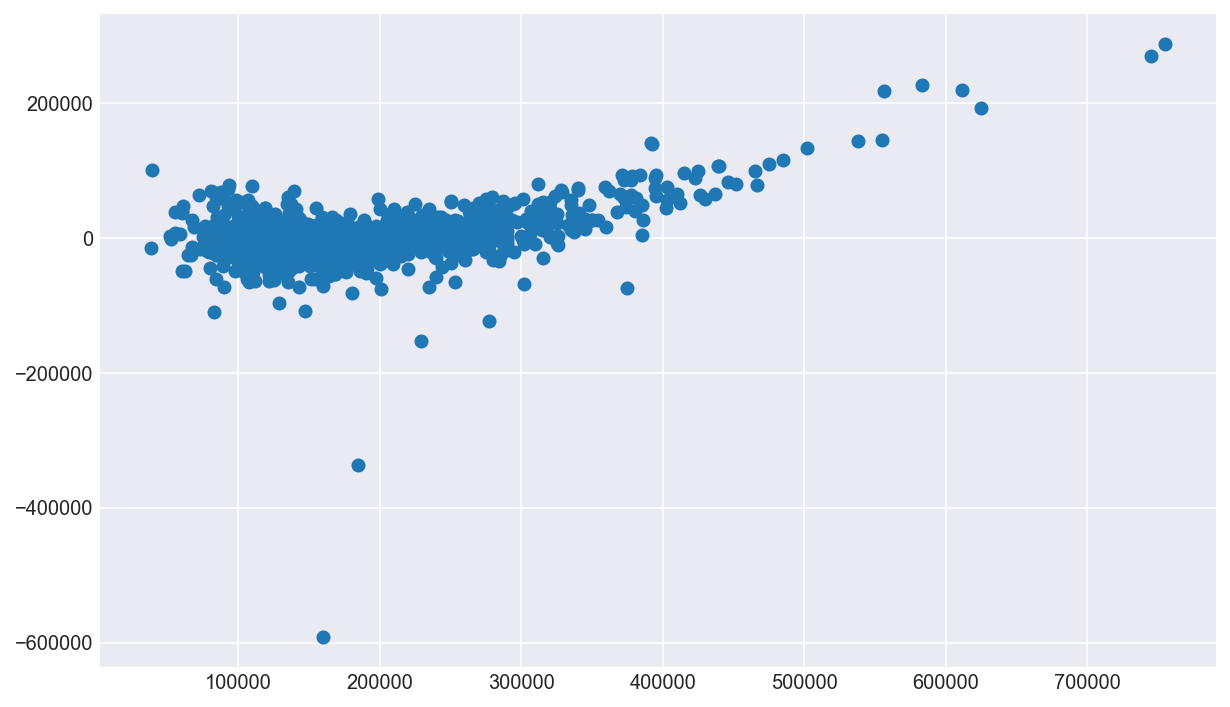

In [107]:
fig = plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.scatter(df["SalePrice"], residuals_fixed)
plt.show()

Plotting the residuals vs prices shows that as price increases our Sale Price predictions are too low. We've confirmed this previously but good to see this on a residual versus Sale Price chart. 

We may wish to further break up our predictions into 2 groups: one for houses >= 350K and one for houses < 350K, since the +350K houses have larger residuals.

### What changeable features we can use to explain the fixed model residuals?

In [108]:
# Changeable features
renov_features = residential4[['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2',
'HeatingQC','KitchenQual','CentralAir','Electrical','FireplaceQu','GarageQual','GarageCond',
'RoofMatl','RoofStyle','Exterior1st','Exterior2nd','PoolQC']]
renov_features.head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,CentralAir,Electrical,FireplaceQu,GarageQual,GarageCond,RoofMatl,RoofStyle,Exterior1st,Exterior2nd,PoolQC
0,Gd,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None
1,Gd,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,TA,TA,TA,CompShg,Gable,VinylSd,VinylSd,None
2,Gd,TA,90,TA,Unf,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None
3,TA,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None
4,TA,Gd,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None


Let's go through the feature columns and map categorical variables to specific numbers, which we can rank. We apply the following system:

    None=0
    Poor=1
    Fair=2
    Typical=3
    Good=4
    Excellent=5

***By assigning an ordinal match to the quality variables we are quantifying them, in effect making "Good" worth twice as much as "Fair" while "Excellent" is worth five times as much as "Poor". This will have an effect on any linear models we attempt to fit to this.***

In [109]:
# Let's construct a dictionary to accomplish this:
quality_dict = {'Po':1, 'Fa':2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'None':0}
bsmt_dict = {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, 'None':0}
print quality_dict
print bsmt_dict

{'None': 0, 'Fa': 2, 'Gd': 4, 'Ex': 5, 'Po': 1, 'TA': 3}
{'None': 0, 'LwQ': 2, 'BLQ': 4, 'Unf': 1, 'Rec': 3, 'GLQ': 6, 'ALQ': 5}


In [110]:
# Applying the dictionary mapping across all columns
renov_f2 = renov_features.copy()
renov_f2['ExterQualRank'] = renov_f2['ExterQual'].map(lambda x: quality_dict[x])
renov_f2['ExterCondRank'] = renov_f2['ExterCond'].map(lambda x: quality_dict[x])
renov_f2['BsmtCondRank'] = renov_f2['BsmtCond'].map(lambda x: quality_dict[x])
renov_f2['FireplaceQualRank'] = renov_f2['FireplaceQu'].map(lambda x: quality_dict[x])
renov_f2['GarageQualRank'] = renov_f2['GarageQual'].map(lambda x: quality_dict[x])
renov_f2['GarageCondRank'] = renov_f2['GarageCond'].map(lambda x: quality_dict[x])
renov_f2['HeatingQCRank'] = renov_f2['HeatingQC'].map(lambda x: quality_dict[x])
renov_f2['KitchenQualRank'] = renov_f2['KitchenQual'].map(lambda x: quality_dict[x])
renov_f2['BsmtFin1Rank'] = renov_f2['BsmtFinType1'].map(lambda x: bsmt_dict[x])
renov_f2['BsmtFin2Rank'] = renov_f2['BsmtFinType2'].map(lambda x: bsmt_dict[x])
renov_f2['PoolQCRank'] = renov_f2['PoolQC'].map(lambda x: quality_dict[x])
renov_f2.head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,CentralAir,Electrical,FireplaceQu,GarageQual,GarageCond,RoofMatl,RoofStyle,Exterior1st,Exterior2nd,PoolQC,ExterQualRank,ExterCondRank,BsmtCondRank,FireplaceQualRank,GarageQualRank,GarageCondRank,HeatingQCRank,KitchenQualRank,BsmtFin1Rank,BsmtFin2Rank,PoolQCRank
0,Gd,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None,4,3,3,0,3,3,5,4,6,1,0
1,Gd,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,TA,TA,TA,CompShg,Gable,VinylSd,VinylSd,None,4,3,3,3,3,3,5,4,6,1,0
2,Gd,TA,90,TA,Unf,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None,4,3,3,0,3,3,5,4,1,1,0
3,TA,TA,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None,3,3,3,0,3,3,5,4,6,1,0
4,TA,Gd,90,TA,GLQ,Unf,Ex,Gd,Y,SBrkr,None,TA,TA,CompShg,Gable,VinylSd,VinylSd,None,3,4,3,0,3,3,5,4,6,1,0


In [111]:
renov_f3 = renov_f2.copy()
renov_f3.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond','FireplaceQu',
               'GarageQual','GarageCond','HeatingQC','KitchenQual','BsmtFinType1',
               'BsmtFinType2','PoolQC'], axis=1, inplace=True)
renov_f3.head()

,CentralAir,Electrical,RoofMatl,RoofStyle,Exterior1st,Exterior2nd,ExterQualRank,ExterCondRank,BsmtCondRank,FireplaceQualRank,GarageQualRank,GarageCondRank,HeatingQCRank,KitchenQualRank,BsmtFin1Rank,BsmtFin2Rank,PoolQCRank
0,Y,SBrkr,CompShg,Gable,VinylSd,VinylSd,4,3,3,0,3,3,5,4,6,1,0
1,Y,SBrkr,CompShg,Gable,VinylSd,VinylSd,4,3,3,3,3,3,5,4,6,1,0
2,Y,SBrkr,CompShg,Gable,VinylSd,VinylSd,4,3,3,0,3,3,5,4,1,1,0
3,Y,SBrkr,CompShg,Gable,VinylSd,VinylSd,3,3,3,0,3,3,5,4,6,1,0
4,Y,SBrkr,CompShg,Gable,VinylSd,VinylSd,3,4,3,0,3,3,5,4,6,1,0


In [112]:
# Convert to dummies.
renov_dummies = pd.get_dummies(renov_f3[['CentralAir','Electrical',
                            'RoofMatl','RoofStyle','Exterior1st','Exterior2nd']])
renov_dummies.head()

,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [113]:
renov = pd.concat([renov_f3.iloc[:,7:], renov_dummies.reset_index()], axis=1)
renov.drop('index', axis=1, inplace=True)
renov.tail()

,ExterCondRank,BsmtCondRank,FireplaceQualRank,GarageQualRank,GarageCondRank,HeatingQCRank,KitchenQualRank,BsmtFin1Rank,BsmtFin2Rank,PoolQCRank,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
1445,3,3,0,0,0,5,4,3,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1446,3,3,3,3,3,3,3,6,3,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1447,3,3,4,3,3,2,3,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1448,3,3,4,2,1,2,2,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1449,3,3,0,2,3,4,3,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [114]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
renov_scaled = scaler.fit_transform(renov)
renov_scaled_features = pd.DataFrame(renov_scaled, columns=renov.columns)
renov_scaled_features.head()

,ExterCondRank,BsmtCondRank,FireplaceQualRank,GarageQualRank,GarageCondRank,HeatingQCRank,KitchenQualRank,BsmtFin1Rank,BsmtFin2Rank,PoolQCRank,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,0.50,0.75,0.0,0.6,0.6,1.0,0.666667,1.000000,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.50,0.75,0.6,0.6,0.6,1.0,0.666667,1.000000,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.50,0.75,0.0,0.6,0.6,1.0,0.666667,0.166667,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.50,0.75,0.0,0.6,0.6,1.0,0.666667,1.000000,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.75,0.75,0.0,0.6,0.6,1.0,0.666667,1.000000,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [115]:
# Augment to residuals from fixed model
X_augment = pd.concat([renov_scaled_features, residuals_fixed.reset_index()], axis=1)
X_augment.drop('index', axis=1, inplace=True)
X_augment.tail()

,ExterCondRank,BsmtCondRank,FireplaceQualRank,GarageQualRank,GarageCondRank,HeatingQCRank,KitchenQualRank,BsmtFin1Rank,BsmtFin2Rank,PoolQCRank,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Residuals
1445,0.5,0.75,0.0,0.0,0.0,1.00,0.666667,0.500000,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11017.210481
1446,0.5,0.75,0.6,0.6,0.6,0.50,0.333333,1.000000,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12197.211028
1447,0.5,0.75,0.8,0.6,0.6,0.25,0.333333,0.166667,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-45348.532575
1448,0.5,0.75,0.8,0.4,0.2,0.25,0.000000,0.166667,0.166667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7044.296397
1449,0.5,0.75,0.0,0.4,0.6,0.75,0.333333,0.166667,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3469.687685


In [116]:
target_new = X_augment.Residuals
X_new = X_augment.drop('Residuals', axis=1)

### Grid Search with ElasticNet

In [117]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "l1_ratio": np.linspace(0.01,1,30),
    "alpha": np.logspace(.01, 10, 40)}
en = ElasticNet()
en_gscv = GridSearchCV(en, param_grid=param_grid, verbose=1, cv=5, n_jobs=-1)

In [118]:
resid_predict = en_gscv.fit(X_new, target_new).predict(X_new)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/skle

In [119]:
en_gscv.best_params_

{'alpha': 206.72100865923898, 'l1_ratio': 1.0}

In [120]:
en_gscv.score(X_new, target_new)

0.24030465128323109

Interesting, considering we've given the model the entire dataset to play with. These additional renovatable features can only explain 24.5% of the residuals of the fixed model. The sale price of a house is primarily determined by its fixed features. Since the L1 ratio of this ElasticNet is 1, this is essentially a Lasso regression.

### Confirming with Grid Search with Lasso

In [121]:
param_grid = {"alpha": np.logspace(.01, 10, 40)}
lasso = Lasso()
l_gscv = GridSearchCV(lasso, param_grid=param_grid, verbose=1, cv=5)

In [122]:
l_gscv.fit(X_new, target_new)

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.02329e+00,   1.84567e+00,   3.32895e+00,   6.00429e+00,
         1.08297e+01,   1.95330e+01,   3.52308e+01,   6.35443e+01,
         1.14612e+02,   2.06721e+02,   3.72854e+02,   6.72500e+02,
         1.21296e+03,   2.18776e+03,   3.94597e+03,   7.11718e+03,
         1....,   5.23879e+08,   9.44897e+08,
         1.70427e+09,   3.07392e+09,   5.54429e+09,   1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [123]:
l_gscv.best_params_

{'alpha': 206.72100865923898}

In [124]:
l_gscv.score(X_new, target_new)
# Same score, here. Using th

0.24030465128323109

In [125]:
# What if we want to look at median absolute error?
median_absolute_error(l_gscv.predict(X_new), target_new)

12899.948038141429

Once we've used the fixed model to calculate residuals, using a lasso model to regress these residuals against renovatable features means we are ~$13,000 from the sale price of a house.

In [126]:
elements = sorted(zip(l_gscv.best_estimator_.coef_, X_new.columns))
# List of features with positive coefficients
regularized_features = [x[1] for x in elements if x[0]>0]
print regularized_features

['Exterior2nd_VinylSd', 'FireplaceQualRank', 'RoofStyle_Hip', 'Exterior1st_CemntBd', 'Exterior1st_BrkFace', 'RoofMatl_WdShngl', 'KitchenQualRank']


In [127]:
lgscv_renovatable_df = pd.DataFrame({
    'Feature': X_new.columns,
    'Coefficient': l_gscv.best_estimator_.coef_
},columns=['Feature', 'Coefficient'])
lgscv_renovatable_df.sort_values('Coefficient', ascending=False, inplace=True)
lgscv_renovatable_df.head()

,Feature,Coefficient
6,KitchenQualRank,26001.153932
24,RoofMatl_WdShngl,19857.081458
34,Exterior1st_BrkFace,9170.744667
36,Exterior1st_CemntBd,2493.033615
28,RoofStyle_Hip,1673.796848


It seems as though renovating the *kitchen quality*, *wood shingling* the roof or a improving a home's *fireplace quality* are the easiest ways to increase the value of a property. 

***Confirming other linear models will not fare well either***

In [128]:
ols2 = LinearRegression()
huber2 = HuberRegressor()
ts2 = TheilSenRegressor()
ransac2 = RANSACRegressor()

In [129]:
ransac2.fit(X_new, target_new)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [130]:
huber2.fit(X_new, target_new)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [131]:
ts2.fit(X_new, target_new)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [132]:
ols2.fit(X_new, target_new)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
# Print R_squared
print "R-squared of fitting a RANSAC model of renovatable features to the fixed model residuals is", ransac2.score(X_new, target_new)
print "R-squared of fitting a Huber model of renovatable features to the fixed model residuals is", huber2.score(X_new, target_new)
print "R-squared of fitting a Theil-Sen model of renovatable features to the fixed model residuals is", ts2.score(X_new, target_new)
print "R-squared of fitting a OLS model of renovatable features to the fixed model residuals is", ols2.score(X_new, target_new)

R-squared of fitting a RANSAC model of renovatable features to the fixed model residuals is -2.04141539963e+21
R-squared of fitting a Huber model of renovatable features to the fixed model residuals is 0.0992751562137
R-squared of fitting a Theil-Sen model of renovatable features to the fixed model residuals is 0.094353726379
R-squared of fitting a OLS model of renovatable features to the fixed model residuals is 0.325556304646


That was painful. OLS is our single best performer in terms of R-squared, which should not come as a surprise since that's exactly what it does. Using the OLS model on the residuals of the fixed model we are able to explain 33% of the remaining variance of the fixed model using renovatable features.

What about median absolute error? As shown below, the Huber regressor minimizes this across the entire dataset.

In [134]:
# Median Absolute Error
print "Using OLS Regression on average our estimate of house prices misses by", \
median_absolute_error(ols2.predict(X_new), target_new)
print "Using Theil-Sen Regression on average our estimate of house prices misses by", \
median_absolute_error(ts2.predict(X_new), target_new)
print "Using RANSAC Regression on average our estimate of house prices misses by", \
median_absolute_error(ransac2.predict(X_new), target_new)
print "Using Huber Regression on average our estimate of house prices misses by", \
median_absolute_error(huber2.predict(X_new), target_new)

Using OLS Regression on average our estimate of house prices misses by 12981.6064133
Using Theil-Sen Regression on average our estimate of house prices misses by 12782.7720853
Using RANSAC Regression on average our estimate of house prices misses by 13400.3783369
Using Huber Regression on average our estimate of house prices misses by 11965.641687


In [135]:
elements = sorted(zip(huber2.coef_, X_new.columns))
top_features = [x[1] for x in elements if x[0]>0]
print top_features

['Exterior1st_MetalSd', 'Exterior2nd_MetalSd', 'RoofMatl_Metal', 'Exterior2nd_ImStucc', 'RoofStyle_Hip', 'BsmtFin1Rank', 'Exterior2nd_VinylSd', 'CentralAir_N', 'CentralAir_Y', 'Exterior2nd_AsphShn', 'HeatingQCRank', 'RoofStyle_Gambrel', 'Exterior2nd_Wd Sdng', 'Electrical_FuseA', 'Exterior1st_HdBoard', 'Electrical_SBrkr', 'RoofStyle_Flat', 'RoofMatl_Membran', 'Exterior2nd_Stone', 'Exterior2nd_Brk Cmn', 'Exterior1st_WdShing', 'PoolQCRank', 'Exterior2nd_CmentBd', 'Electrical_FuseF', 'Exterior1st_Stucco', 'Exterior2nd_Other', 'KitchenQualRank', 'Exterior1st_BrkFace', 'RoofMatl_WdShngl']


In [136]:
top_renovatable_df = pd.DataFrame({
    'Feature': X_new.columns,
    'Coefficient': huber2.coef_
}, columns=['Feature','Coefficient'])
top_renovatable_df.sort_values('Coefficient', ascending=False, inplace=True)
top_renovatable_df.head(10)

,Feature,Coefficient
24,RoofMatl_WdShngl,20770.818887
34,Exterior1st_BrkFace,17709.996323
6,KitchenQualRank,14675.735778
55,Exterior2nd_Other,12340.401620
42,Exterior1st_Stucco,11390.491625
13,Electrical_FuseF,9475.778921
51,Exterior2nd_CmentBd,8665.874122
9,PoolQCRank,7025.893033
45,Exterior1st_WdShing,6917.821150
48,Exterior2nd_Brk Cmn,6514.735970


Clearly using linear models to regress the residuals of the fixed model against renovatable features gets us as close as \$12,027 from the actual sale price using a Huber regressor. Once again the features that appear to give us the greatest monetary reward from renovation include shingling the roof, installing a brick face exterior and improving the kitchen quality.

We should be a little wary about using linear models here, particularly because many of our quality variables have been mapped to an ordinal scale which means we are indirectly quantifying that a particular qualitative feature is twice or thrice as good as another feature. This can affect linear models when we try to fit them. 

It's natural to ask if we can get higher scores using non-linear models. We explore this next.

### Using Decision Tree Regression to identify salient renovatable features.

In [137]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=3)
dtr.fit(X_new, target_new)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [138]:
dtr.score(X_new, target_new)

0.34615924213938776

Our highest score so far. We can explain up to 35% of the residuals of the fixed model with renovatable features using a single decision tree with three splits. Since we're fitting the entire dataset here without cross-validating we should control for the possibility of overfitting. Hence, we choose to set max_depth = 3.

In [139]:
elements = sorted(zip(dtr.feature_importances_, X_new.columns))
top_features = [x[1] for x in elements if x[0]>0]
print top_features

['Exterior1st_HdBoard', 'BsmtFin1Rank', 'KitchenQualRank', 'RoofMatl_ClyTile']


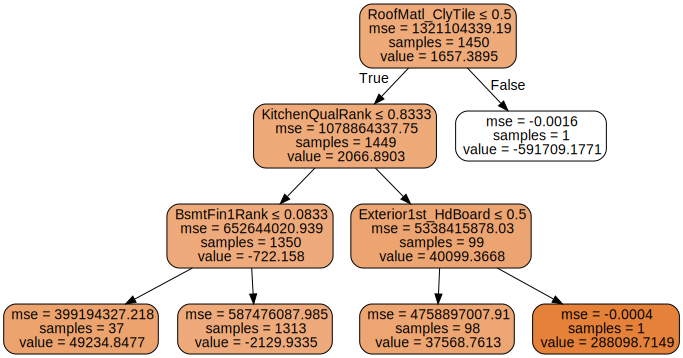

In [140]:
# Let's visualize this tree
import sklearn.tree
import graphviz
home_data = sklearn.tree.export_graphviz(dtr, out_file=None, 
                                        feature_names=X_new.columns,
                                       filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(home_data)
graph

What our Decision Tree tells us:

The single most important factor to increasing the sale price of a home once all fixed factors have been accounted for is not using a clay tiled roof. Not using clay tiles adds \$60,000+ to the value of a home. This would be the first means to renovate a house and flip it over.

Renovating a kitchen quality from fair to good or better, will add \$40,000+ to the value of a house. Once this is done, rather surprisingly, the basement finishing is important. It appears that unfinished basements are worth \$54,000 more than finished basements. This seems counterintuitive and may be caused by the tree overfitting, or maybe residents don't want finished basements so that they can retool them to their liking.

For houses with non-clay roofs and good quality kitchens, ensuring the exterior covering material is Hard Board will add a further $10,000 to the value of the home.

### Random Forest Regressors

With a random forest regressor we take different, multiple samples of the training dataset and a different decision tree is trained on each sample and then averaging across trees. Each time a split occurs a random set of features is chosen from the full set of candidates and the split only uses those features. Decision trees will often split on the most predictive features and will therefore be correlated. By occasionally dropping some features from decision trees we ensure that our random forests are not filled with correlated trees.

In [141]:
from sklearn.ensemble import RandomForestRegressor
rand_forest = RandomForestRegressor()
# Limiting the max depth once again to prevent overfitting
rand_forest2 = RandomForestRegressor(max_depth=3)
rand_forest.fit(X_new, target_new)
rand_forest2.fit(X_new, target_new)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [142]:
# Allowing for overfitting we do quite well...
rand_forest.score(X_new, target_new)

0.45357208112306813

In [143]:
# More in line with our decision trees
rand_forest2.score(X_new, target_new)

0.31879184571410946

In [144]:
feature_importance_df = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': rand_forest2.feature_importances_
}, columns=['Feature', 'Importance'])
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)
feature_importance_df.head(10)

,Feature,Importance
17,RoofMatl_ClyTile,0.393424
6,KitchenQualRank,0.274179
1,BsmtCondRank,0.091527
9,PoolQCRank,0.060006
37,Exterior1st_HdBoard,0.056161
7,BsmtFin1Rank,0.049797
53,Exterior2nd_ImStucc,0.017142
18,RoofMatl_CompShg,0.013715
2,FireplaceQualRank,0.012544
34,Exterior1st_BrkFace,0.010678


Our random forest regressors match the features highlighted by our decision trees, and hinted at by our linear model. In terms of feature importance, kitchen quality, basement condition and clay tile roofs are a few of the renovatable features that can increase the value of a home.

We see that having a pool makes a difference as does the finishing of a basement. Note that in terms of renovating the exterior of a home, hard board and stucco exteriors do add some value as do wood shingled roofs and the quality of heating.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [145]:
# A: We use a logistic regression to predict abnormal sales
# Our target variable is Sale Condition
target = residential4.SaleCondition
target.describe()

count       1450
unique         6
top       Normal
freq        1194
Name: SaleCondition, dtype: object

In [146]:
target.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

Note that we have an imbalanced class here as the number of properties classified as abnormal make up 6% of the dataset.

In [147]:
# Create dummy target
target_dummy = pd.get_dummies(target)
target_dummy.head()

,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [148]:
y = target_dummy.Abnorml.values

In [204]:
# Define new predictor variables - a combination of the best performing fixed and renovatable features. 
# Now we can also include Sale Price and Year Sold.
X = residential4[['SalePrice','LotArea','GrLivArea','YearBuilt','YearRemodAdd',
                  'PoolArea','OverallQual','OverallCond','YrSold']]

In [205]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## Baseline Model

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score
from sklearn.dummy import DummyRegressor
(X_train, X_test, y_train, y_test) = train_test_split(X[['SalePrice']], y)
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
# Once again the dummy variable has set the bar quite low.
dummy.score(X_test, y_test)

-2.3966932194419144e-07

## Logistic Regression

In [207]:
# Standardize with MinMaxScaler
scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X)
lr = LogisticRegression()
cross_val_score(lr, X_standardized, y, cv=10).mean()
# This is close to 1 but don't forget we have a high class imbalance

0.93380963627775149

In [208]:
# Train Test Split our data using a 50/50 split.
(X_train, X_test, y_train, y_test) = train_test_split(X_standardized, y, test_size=0.5)

In [239]:
lr_gridsearch = GridSearchCV(LogisticRegression(), 
                             param_grid={'penalty' : ['l1','l2'],
                                        'C' : [50]},
                            cv=25, n_jobs=-1, verbose=1)
lr_gridsearch.fit(X_train, y_train)

Fitting 25 folds for each of 2 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


GridSearchCV(cv=25, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [240]:
y_pred = lr_gridsearch.predict(X_test)
y_pred_pp = lr_gridsearch.predict_proba(X_test)
y_pred_pp[0:5]
# We see that the abnormal class is in the minority

array([[ 0.96921929,  0.03078071],
       [ 0.98271314,  0.01728686],
       [ 0.93323172,  0.06676828],
       [ 0.96224901,  0.03775099],
       [ 0.88874678,  0.11125322]])

In [241]:
pp = pd.DataFrame(y_pred_pp, columns=['Normal','Abnormal'])
pp.head()

,Normal,Abnormal
0,0.969219,0.030781
1,0.982713,0.017287
2,0.933232,0.066768
3,0.962249,0.037751
4,0.888747,0.111253


In [242]:
# Print confusion matrix
conf_mat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
cf = pd.DataFrame(conf_mat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
cf
# We do not predict any true positives or false negatives due to the imbalance. 

,predicted_Abnormal,predicted_Normal
Abnormal,0,53
Normal,0,672


In [243]:
# To predict more abnormal sales, let's put the threshold up to 10%
pp['abnormal_thresh_10'] = [1 if x >= 0.1 else 0 for x in pp.Abnormal.values]
pp.head(10)

,Normal,Abnormal,abnormal_thresh_10
0,0.969219,0.030781,0
1,0.982713,0.017287,0
2,0.933232,0.066768,0
3,0.962249,0.037751,0
4,0.888747,0.111253,1
5,0.960374,0.039626,0
6,0.904980,0.095020,0
7,0.946959,0.053041,0
8,0.975781,0.024219,0
9,0.981737,0.018263,0


In [244]:
conmat_thresh_10 = np.array(confusion_matrix(y_test, pp.abnormal_thresh_10.values, labels=[1,0]))
conf_thresh_10 = pd.DataFrame(conmat_thresh_10, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
print 'Confusion matrix with 10% prediction threshold'
conf_thresh_10

Confusion matrix with 10% prediction threshold


,predicted_Abnormal,predicted_Normal
Abnormal,15,38
Normal,109,563


Lowering the threshold improved the number of abnormal sales predicted at the expense of increased False negatives.

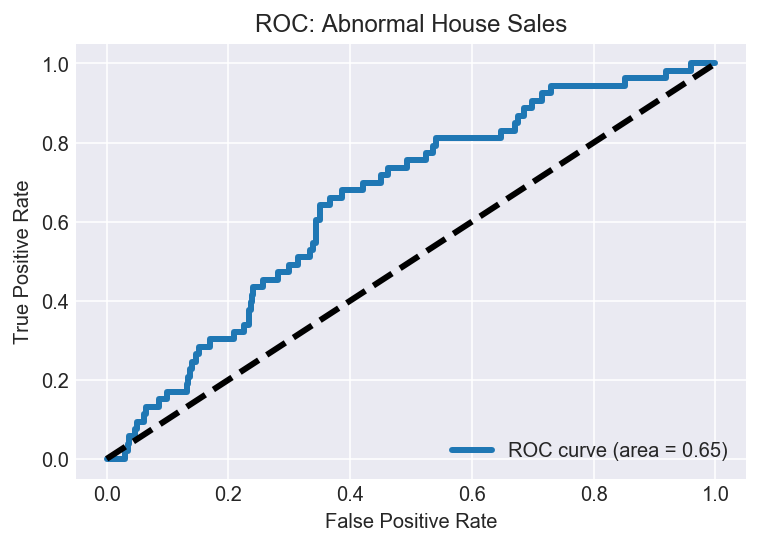

In [245]:
#ROC/AUC plot of the original and threshold
fpr, tpr, _ = roc_curve(y_test, y_pred_pp[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6,4])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Abnormal House Sales')
plt.legend(loc="lower right")
plt.show()

# Miscellaneous Code - Ignore everything below this.

### Cross Check R-squared

In [ ]:
def adjusted_rsquared(X, y):
    # Assures we don't overfit the model by just throwing an aribtrary number of variables in there
    model.fit(X,y)
    yhat = model.predict(X)
    SSR = sum((y-yhat)**2)
    SST = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SSR))/SST
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return [item for sublist in [list(r_squared), list(adjusted_r_squared)] for item in sublist]

In [ ]:
# This is used for classification as opposed to regression
# accuracy_score

In [ ]:
# This line of code also works
residential4.corr().SalePrice.sort_values(ascending=False)